# Competencia Métodos Base de datos Conteo

Javier Arturo Rozo Alzate - jarozoa@eafit.edu.co  
Alejandro Palacio Vasquez - apalac19@eafit.edu.co  
Liceth Cristina Mosquera Galvis - lcmosquerg@eafit.edu.co  
Cristian David Muñoz Mora - cdmunozm@eafit.edu.co  
Programa: Metodos Estadısticos Avanzados  
Docente:Andres Ramirez Hassan - aramir21@eafit.edu.co  
12 de octubre de 2019<br>

# Análisis Exploratorios de datos

Bibliotecas

In [1]:
# Pandas para cargar los datos y manipularlos
import pandas as pd


# Funciones numéricas

import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
from numpy import sort
import collections
import math
import operator
from scipy import stats
from math import ceil
import time
import random as rnd
import statsmodels
import pandas_profiling
 
# Graficar
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

# Modelar
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,train_test_split
from sklearn.metrics import make_scorer,r2_score,mean_squared_error,explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.preprocessing import StandardScaler,minmax_scale
from sklearn.feature_selection import SelectFromModel
from statsmodels.formula.api import poisson, negativebinomial,glm



import warnings
warnings.filterwarnings("ignore")

# Carga de datos

In [2]:
# Cargar los datos
datos = pd.read_csv('datacountstudents.csv')

In [3]:
# Análisis de los datos
profile=pd.read_csv('datacountstudents.csv').profile_report() 
profile = datos.profile_report(title='Pandas Profiling Report')
#profile.to_file(output_file="output.html")
profile

Alta correlación entre las variable X1 con las X2, x11 y x17, la x2 con la X11, la x31 con la x32, la x25 con la x26, x21 con x15 y x23, 

Se probaron las correlaciones con medidas no paramétricas y estas se siguen manteniendo

Se puede notar que gran cantidad de outliers en x10,x12, x24 y x27, sin embargo debido a la poca cantidad de datos y al no tener mayor información de estas variables se debe trabajar con estos datos.

Se estandarizan las variables continuas dependientes.
Se divide los 150 datos en test y training, se halla la media y la varianza del training y se transforma el test.

In [4]:
# Dataframe de solo continuas
Datos_con = datos.select_dtypes(exclude=['int64'])
Columns_C = Datos_con.columns[(Datos_con.dtypes.values == np.dtype('float64'))]
# Estandarizar solo continuas en train
col_names = Columns_C[0:13]
features_df = Datos_con[col_names]
scaler = StandardScaler().fit(features_df.values)
features_df = scaler.transform(features_df.values)
Datos_con[col_names] = features_df
#DATAFRAME variables continuos
Datos_con = pd.concat([Datos_con], axis=1, sort=False)
#Datos_con.head()

In [5]:
# Dataframe completo
Datos_sc = datos.select_dtypes(exclude=['int64'])
# Estandarizar solo continuas en train
Datos_sc = datos.copy()
features_df = Datos_sc[col_names]
features_df = scaler.transform(features_df.values)
Datos_sc[col_names] = features_df
# Dataframe escalado
Datos_sc = pd.concat([Datos_sc], axis=1, sort=False)
Datos_sc = Datos_sc.iloc[:,1:]
# Preparando para modelar
X = Datos_sc.drop(['yC'], axis=1)
y = Datos_sc['yC'].values
Datos_sc.head()

yC        x1        x2  x3  x4  x5  x6  x7        x8  x9    ...     \
0   1 -1.443483  1.662606   1   0   0   0   0  0.476844   0    ...      
1   0  0.750834 -0.378196   0   0   0   0   1 -0.207152  44    ...      
2   0  0.240590 -0.208129   0   1   0   0   0  0.866395  27    ...      
3   0 -2.258116  1.983304   0   0   1   0   0  0.473537   0    ...      
4   2  0.702415 -0.635726   1   0   0   0   0 -2.233465  31    ...      

        x23       x24  x25  x26       x27  x28  x29  x30       x31       x32  
0  2.092018 -0.240894    6    6 -1.124346    0    0    7 -1.173105 -1.267575  
1  0.516205 -0.243133    8    4 -0.845203    0    0    7  1.926569  1.326759  
2  2.075141 -0.243133    6    6 -0.629555    0    1    4 -1.114558 -1.196908  
3 -0.659147 -0.242387    6    4 -0.389961    0    0    7 -0.776095 -0.774072  
4 -0.670589 -0.243133    5    7  2.036944    0    0    3  0.183521  0.458084  

[5 rows x 33 columns]

In [6]:
# Nombres columnas numéricas
dtypes = datos.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist() 

col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = datos[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous and',
      len(cols_discrete),'are discrete.')


34 numeric columns, of which 15 are continuous and 19 are discrete.


<IPython.core.display.Javascript object>


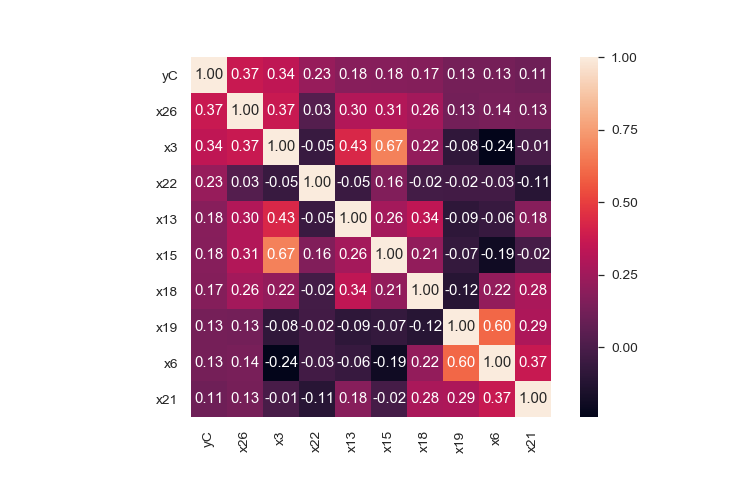

In [8]:
#mapa de calor con las variables más correlacionadas con yC
%matplotlib notebook
#saleprice correlation matrix
corrmat = Datos_sc.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'yC')['yC'].index
cm = np.corrcoef(Datos_sc[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}
                 , yticklabels=cols.values, xticklabels=cols.values)
sns.set(font_scale=1.25)
plt.show()

# Selección de Variables

Selección hiperparámetros

In [9]:
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8,1],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[1000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  }

In [10]:
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=10, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False
                        , verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X,y)
print (gsearch1.scorer_ ) 
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    9.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   11.2s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   11.8s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.9s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   14.7s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   16.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   17.7s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   18.8s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   21.6s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:   25.7s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   27.4s
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:   30.1s
[Parallel(

[Parallel(n_jobs=6)]: Done 9373 tasks      | elapsed: 32.8min
[Parallel(n_jobs=6)]: Done 9510 tasks      | elapsed: 33.3min
[Parallel(n_jobs=6)]: Done 9649 tasks      | elapsed: 33.9min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 34.4min
[Parallel(n_jobs=6)]: Done 9929 tasks      | elapsed: 35.0min
[Parallel(n_jobs=6)]: Done 10070 tasks      | elapsed: 35.6min
[Parallel(n_jobs=6)]: Done 10213 tasks      | elapsed: 36.0min
[Parallel(n_jobs=6)]: Done 10356 tasks      | elapsed: 36.7min
[Parallel(n_jobs=6)]: Done 10368 out of 10368 | elapsed: 36.8min finished


[23:09:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
make_scorer(mean_squared_error, greater_is_better=False)
best params
{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 1000, 'reg_alpha': 1e-05, 'reg_lambda': 0.45, 'subsample': 0.6}
best score
-1.5082628126939879


In [12]:
#cargando datos enmatriz de XGB
data_dmatrix = xgb.DMatrix(data=X,label=y)
#obtener los mejores parametros de la iteración
#params={'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5
#        , 'n_estimators': 1000, 'reg_alpha': 1e-05, 'reg_lambda': 0.45, 'subsample': 0.6}
params =gsearch1.best_params_ 

In [13]:
#entrenando el modelo
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=15)

<IPython.core.display.Javascript object>


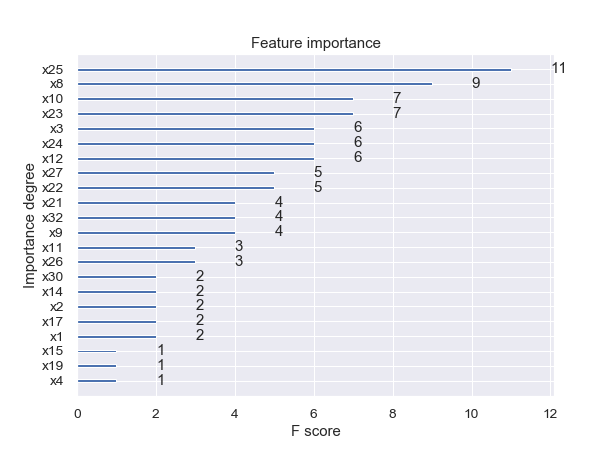

In [14]:
#plotear las variables en orden de importancia 
xgb.plot_importance(xg_reg)
sns.set(font_scale=2)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}	
plt.rcParams.update({'font.size': 15})
plt.ylabel('Importance degree', fontsize = 15)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

In [15]:
# Validación cruzada del modelo
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         1.480461        0.073943        1.463434       0.305800
1         1.409022        0.063269        1.420381       0.305558
2         1.354182        0.060863        1.383073       0.312504
3         1.294505        0.064450        1.342391       0.296879
4         1.242476        0.060612        1.322956       0.294118

In [16]:
print((cv_results["test-rmse-mean"]).tail(5))

17    1.202972
18    1.197636
19    1.195829
20    1.198814
21    1.195637
Name: test-rmse-mean, dtype: float64


# Modelo

In [17]:
#cargar los datos y escoger la variable dependiente
datos = pd.read_csv('datacountstudents.csv')
datos = datos.iloc[:,1:]
X2 = datos.drop(['yC'], axis=1)
y2 = datos['yC'].values

Divido los datos para entrenamiento y testeo

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size = 0.3, random_state=42)

Se estandarizan las variables continuas y se crean data frame de las mismas

In [19]:
# Nombres columnas continuas
train_C = X_train.select_dtypes(exclude=['int64'])
Columns_C = X_train.columns[(X_train.dtypes.values == np.dtype('float64'))]

# Estandarizar solo continuas en train
X_train_sc = X_train.copy()
col_names = Columns_C[0:13]
features_tr = X_train_sc[col_names]
scaler = StandardScaler().fit(features_tr.values)
features_tr = scaler.transform(features_tr.values)
X_train_sc[col_names] = features_tr

# Estandarizar solo continuas en test
X_test_sc = X_test.copy()
features_ts = X_test_sc[col_names]
features_ts = scaler.transform(features_ts.values)
X_test_sc[col_names] = features_ts

# Dataframes
X_train_sc = pd.concat([X_train_sc], axis=1, sort=False)
X_test_sc = pd.concat([X_test_sc], axis=1, sort=False)
#X_train_sc.head()

In [20]:
# Evaluación parametros modelo
ts = time.time()

model = XGBRegressor(
    colsample_bytree=0.6, 
    gamma= 0.3,
    learning_rate= 0.1,
    max_depth=3,
    min_child_weight=1.5, 
    n_estimators=1000,    
    reg_alpha= 1e-05,
    reg_lambda= 0.45,
    subsample=0.6,
    #params,
    seed=42
    , base_score=0.7 
    , booster='gbtree'
    , colsample_bylevel=0.6
    , max_delta_step=3
    , missing=None
    , n_jobs=1
    , nthread=None
    , objective='reg:squarederror'
    , random_state=0
    , scale_pos_weight=1
    , silent=True)
   
model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 50)

time.time() - ts

[0]	validation_0-rmse:1.45355	validation_1-rmse:1.33572
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.4023	validation_1-rmse:1.29272
[2]	validation_0-rmse:1.32556	validation_1-rmse:1.26275
[3]	validation_0-rmse:1.27299	validation_1-rmse:1.23664
[4]	validation_0-rmse:1.22883	validation_1-rmse:1.22922
[5]	validation_0-rmse:1.1819	validation_1-rmse:1.23464
[6]	validation_0-rmse:1.15355	validation_1-rmse:1.22385
[7]	validation_0-rmse:1.13679	validation_1-rmse:1.21558
[8]	validation_0-rmse:1.09837	validation_1-rmse:1.19753
[9]	validation_0-rmse:1.06798	validation_1-rmse:1.20523
[10]	validation_0-rmse:1.03975	validation_1-rmse:1.18834
[11]	validation_0-rmse:1.00982	validation_1-rmse:1.17896
[12]	validation_0-rmse:0.971242	validation_1-rmse:1.18241
[13]	validation_0-rmse:0.950035	validation_1-rmse:1.17774
[14]	validation_0-rmse:0.933927	validation_1-rmse:1.1

0.09125518798828125

In [21]:
selection_model = XGBRegressor(
    colsample_bytree=0.6, 
    gamma= 0.3,
    learning_rate= 0.1,
    max_depth=3,
    min_child_weight=1.5, 
    n_estimators=1000,    
    reg_alpha= 1e-05,
    reg_lambda= 0.45,
    subsample=0.6,
    seed=42
    , base_score=0.7 
    , booster='gbtree'
    , colsample_bylevel=0.6
    , max_delta_step=3
    , missing=None
    , n_jobs=1
    , nthread=None
    , objective='reg:squarederror'
    , random_state=0
    , scale_pos_weight=1
    , silent=True)

In [22]:
# Verificar ajuste de MSE a medida que disminuyen las variables en orden de importancia
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor(colsample_bytree=0.6, eta=0.3,learning_rate= 0.1,max_depth=3,min_child_weight=1.5
                                   , n_estimators=1000,reg_alpha=1e-05,reg_lambda= 0.45, subsample=0.6,seed=42
                                   , base_score=0.7 , booster='gbtree' , colsample_bylevel=0.6 , gamma=0.1
                                   , max_delta_step=3 , missing=None , n_jobs=1, nthread=None 
                                   , objective='reg:squarederror', random_state=0, scale_pos_weight=1 , silent=True)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    MSE = mean_squared_error(y_test, predictions)
    print("MSE:",MSE)
    print("Thresh=%.3f, n=%d, MSE: %.3f",(thresh, select_X_train.shape[1], MSE))
#MSE
#thresh
#select_X_train.shape[1]

MSE: 1.9777777777777779
Thresh=%.3f, n=%d, MSE: %.3f (0.0, 32, 1.9777777777777779)
MSE: 1.9777777777777779
Thresh=%.3f, n=%d, MSE: %.3f (0.0, 32, 1.9777777777777779)
MSE: 1.9777777777777779
Thresh=%.3f, n=%d, MSE: %.3f (0.0, 32, 1.9777777777777779)
MSE: 1.9777777777777779
Thresh=%.3f, n=%d, MSE: %.3f (0.0, 32, 1.9777777777777779)
MSE: 1.9777777777777779
Thresh=%.3f, n=%d, MSE: %.3f (0.0, 32, 1.9777777777777779)
MSE: 2.0
Thresh=%.3f, n=%d, MSE: %.3f (0.009237213, 27, 2.0)
MSE: 1.9555555555555555
Thresh=%.3f, n=%d, MSE: %.3f (0.017227132, 26, 1.9555555555555555)
MSE: 1.8222222222222222
Thresh=%.3f, n=%d, MSE: %.3f (0.018733699, 25, 1.8222222222222222)
MSE: 1.3555555555555556
Thresh=%.3f, n=%d, MSE: %.3f (0.020610604, 24, 1.3555555555555556)
MSE: 1.5333333333333334
Thresh=%.3f, n=%d, MSE: %.3f (0.02090157, 23, 1.5333333333333334)
MSE: 1.5333333333333334
Thresh=%.3f, n=%d, MSE: %.3f (0.021344338, 22, 1.5333333333333334)
MSE: 1.6666666666666667
Thresh=%.3f, n=%d, MSE: %.3f (0.024054619, 21,

In [23]:
# Ajustar el modelo en los datos de entrenamiento
model = XGBRegressor(colsample_bytree=0.6, eta=0.3,learning_rate= 0.1,max_depth=3,min_child_weight=1.5
                                   , n_estimators=1000,reg_alpha=1e-05,reg_lambda= 0.45, subsample=0.6,seed=42
                                   , base_score=0.7 , booster='gbtree' , colsample_bylevel=0.6 , gamma=0.1
                                   , max_delta_step=3 , missing=None , n_jobs=1, nthread=None 
                                   , objective='reg:squarederror', random_state=0, scale_pos_weight=1 , silent=True)
model.fit(X_train_sc, y_train)

# Hacer predicciones para los datos del test y evaluarlos
y_pred = model.predict(X_test_sc)
predictions = [round(value) for value in y_pred]
MSE = mean_squared_error(y_test, predictions)
print("MSE: %.3f" % (MSE))

# Ajustar el modelo usando cada importancia con un umbral (threshold)
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    
    # Selectcionar variables usando el umbral
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train_sc = selection.transform(X_train_sc)
    
    # Entrenar el modelo 
    selection_model = XGBRegressor(colsample_bytree=0.6, eta=0.1,learning_rate= 0.1,max_depth=5,min_child_weight=1.5
                                   , n_estimators=1000,reg_alpha= 0.75, reg_lambda= 0.01, subsample=0.6,seed=42
                                   , base_score=0.7 , booster='gbtree' , colsample_bylevel=0.6 , gamma=0.1
                                   , max_delta_step=3 , missing=None , n_jobs=1, nthread=None 
                                   , objective='reg:squarederror', random_state=0, scale_pos_weight=1 , silent=True
                                  )
    selection_model.fit(select_X_train_sc, y_train)
    
    # Evaluar el modelo
    select_X_test_sc = selection.transform(X_test_sc)
    y_pred = selection_model.predict(select_X_test_sc)
    predictions = [round(value) for value in y_pred]
    MSE = mean_squared_error(y_test, predictions)
   
    print("Thresh=%.3f, n=%d, MSE: %.2f" % (thresh, select_X_train_sc.shape[1], MSE))
print(type(select_X_train_sc))

MSE: 1.889
Thresh=0.000, n=32, MSE: 1.40
Thresh=0.000, n=32, MSE: 1.40
Thresh=0.006, n=30, MSE: 1.82
Thresh=0.008, n=29, MSE: 1.78
Thresh=0.010, n=28, MSE: 1.60
Thresh=0.012, n=27, MSE: 1.53
Thresh=0.013, n=26, MSE: 1.82
Thresh=0.013, n=25, MSE: 1.53
Thresh=0.015, n=24, MSE: 1.69
Thresh=0.015, n=23, MSE: 1.36
Thresh=0.016, n=22, MSE: 1.62
Thresh=0.016, n=21, MSE: 1.87
Thresh=0.018, n=20, MSE: 1.82
Thresh=0.019, n=19, MSE: 1.82
Thresh=0.020, n=18, MSE: 1.96
Thresh=0.021, n=17, MSE: 1.60
Thresh=0.023, n=16, MSE: 1.89
Thresh=0.026, n=15, MSE: 1.58
Thresh=0.026, n=14, MSE: 1.98
Thresh=0.027, n=13, MSE: 1.78
Thresh=0.028, n=12, MSE: 1.73
Thresh=0.029, n=11, MSE: 1.80
Thresh=0.029, n=10, MSE: 1.80
Thresh=0.031, n=9, MSE: 1.64
Thresh=0.033, n=8, MSE: 2.07
Thresh=0.033, n=7, MSE: 1.56
Thresh=0.037, n=6, MSE: 1.80
Thresh=0.049, n=5, MSE: 1.96
Thresh=0.058, n=4, MSE: 1.69
Thresh=0.072, n=3, MSE: 1.42
Thresh=0.112, n=2, MSE: 1.33
Thresh=0.184, n=1, MSE: 1.40
<class 'numpy.ndarray'>


In [24]:
# Dataframe variable e importancia de la varaiable en la construcción del modelo
feature_names = pd.DataFrame(X_train.columns)
Feature=pd.DataFrame(model.feature_importances_)
Feature=pd.concat([feature_names,Feature], axis=1, sort=False)#,index=feature_names,columns=["Feature","importance"])
Feature

0         0
0    x1  0.019755
1    x2  0.025628
2    x3  0.072366
3    x4  0.015004
4    x5  0.000000
5    x6  0.007525
6    x7  0.009575
7    x8  0.037465
8    x9  0.028475
9   x10  0.026263
10  x11  0.033272
11  x12  0.029055
12  x13  0.048938
13  x14  0.030566
14  x15  0.013407
15  x16  0.016277
16  x17  0.019297
17  x18  0.057863
18  x19  0.005853
19  x20  0.012781
20  x21  0.028555
21  x22  0.012243
22  x23  0.021240
23  x24  0.026551
24  x25  0.112383
25  x26  0.184016
26  x27  0.018147
27  x28  0.014696
28  x29  0.000000
29  x30  0.033422
30  x31  0.016130
31  x32  0.023250

<IPython.core.display.Javascript object>


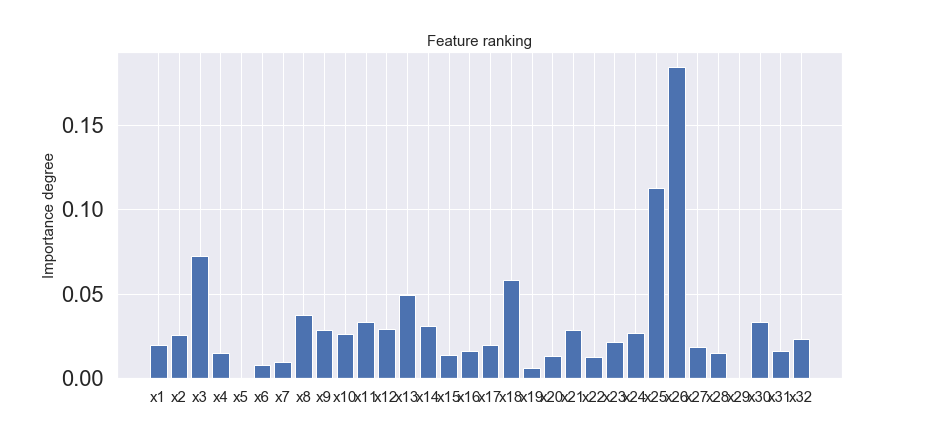

In [25]:
# Graficar importancia de las variables
plt.subplots(figsize=(13, 6))
plt.title('Feature ranking', fontsize = 15)
plt.ylabel('Importance degree', fontsize = 15)

feature_names = X_train.columns
plt.xticks(range(X_train.shape[1]), feature_names, fontsize = 15)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

Se construye el modelo con las variables escogidas

In [26]:
selection_model = XGBRegressor(colsample_bytree=0.6, eta=0.3,learning_rate= 0.1,max_depth=3,min_child_weight=1.5
                                   , n_estimators=1000,reg_alpha=1e-05,reg_lambda= 0.45, subsample=0.6,seed=42
                                   , base_score=0.7 , booster='gbtree' , colsample_bylevel=0.6 , gamma=0.1
                                   , max_delta_step=3 , missing=None , n_jobs=1, nthread=None 
                                   , objective='reg:squarederror', random_state=0, scale_pos_weight=1 , silent=True)

In [27]:
columns=['x25','x3','x23','x8'] 
X_train_sc3=pd.DataFrame(X_train_sc,columns=columns)
X_test_sc3=pd.DataFrame(X_test_sc,columns=columns)

# Ajustar el Modelo
selection_model.fit(X_train_sc3,y_train)

# Hacer modelo de predicción
preds = selection_model.predict(X_test_sc3)
y_ts = pd.DataFrame(y_test,columns=['y_ts'])
pred= pd.DataFrame(np.round(preds),columns=['predict'])

#anexar columna evaluando si el modelo predice los ceros como ceros
Result1= pd.concat([y_ts,pred], axis=1, sort=False)
#Result1['xg_reg_1']= [0]*len(Result1)

sum=0
# columnas convirtiendo los mayores a cero como unos tanto en test como en la predicción
Result1['Mayor0_test'] = (Result1['predict']>0).astype(int)
Result1['Mayor0_real'] = (Result1['y_ts']>0).astype(int)
Result1['prueba']= [0]*len(Result1['Mayor0_real'])
sum=0
for i in range(len(Result1['Mayor0_real'])):
    if Result1.Mayor0_real[i]==Result1.Mayor0_test[i]:
        Result1['prueba'][i]=1
        sum=sum+1
    else: Result1['prueba'] [i]=0


print("Explained_variance_score: ",explained_variance_score(y_test,pred))
print("Test 0 y >0: ",sum/len(Result1['Mayor0_real']))
print("MSE_test:",(mean_squared_error(y_ts, pred)))

%matplotlib notebook
confusion_matrix = pd.crosstab(Result1['Mayor0_test'],Result1['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

#sns.heatmap(confusion_matrix)
#sns.set(font_scale=1)
#sns.heatmap(confusion_matrix, cmap="Blues", annot=True,annot_kws={"size": 20})# font size

Explained_variance_score:  -0.13602693602693616
Test 0 y >0:  0.6444444444444445
MSE_test: 1.6666666666666667
Predicted  0   1
Actual          
0          5   8
1          8  24


In [28]:
for i in range (len(columns)):
    v=vif(np.matrix(X_train_sc3[0:]),i)
    print("Variance inflation factor for {}: {}".format(X_train_sc3.columns[i],round(v,2)))

Variance inflation factor for x25: 1.33
Variance inflation factor for x3: 1.41
Variance inflation factor for x23: 1.02
Variance inflation factor for x8: 1.1


<IPython.core.display.Javascript object>


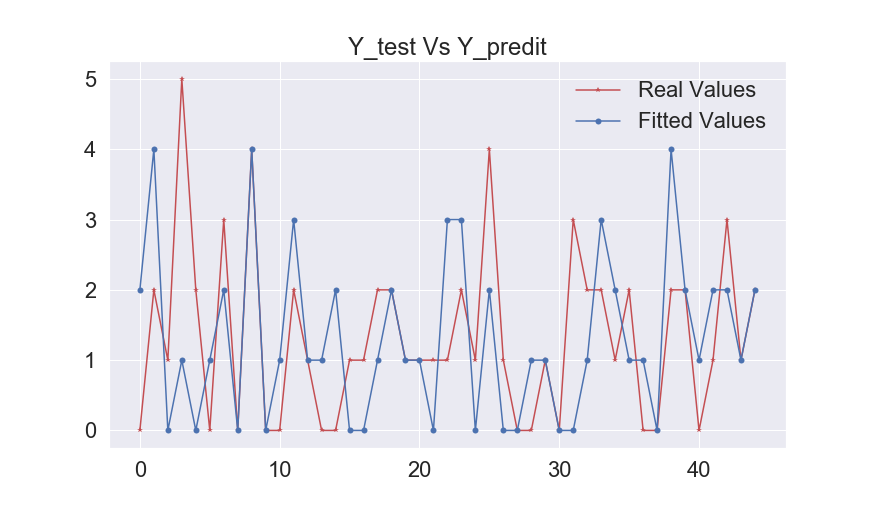

In [29]:
Result = pd.concat([y_ts,pred], axis=1, sort=False)
#Result
#preds = np.round(pred2.iloc[:,1])
%matplotlib notebook
plt.plot(range(len(y_ts)), y_ts, 'r*-', range(len(y_ts)), pred, 'bo-')
plt.title('Y_test Vs Y_predit')
plt.legend(['Real Values', 'Fitted Values'])
plt.show()

In [ ]:
Result

# Construción con otros modelos

Se prueba utilizando el modelo de regresion binomial negativa y regresión Poisson, pero los resultados son menores al contruido con XGboost

In [30]:
#Train Dataframe
#To erase index of X_train
X_train_sc2=X_train_sc.reset_index().values
#y_train as a dataframe
y_train2= pd.DataFrame(y_train,columns=['y_train'])
columns=['id','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19',
         'x20','x21','x22','x23','x24','x25','x26','x27','x28', 'x29', 'x30', 'x31','x32']
#change name of colums of X_train
X_train_sc2= pd.DataFrame(X_train_sc2,columns=columns)#
#drop id
X_train_sc2=X_train_sc2.drop(['id'], axis=1)
#Dataframe y with x's
X_train_sc2 = pd.concat([y_train2,X_train_sc2], axis=1, sort=False)

# Test DataFrame
X_test_sc2=X_test_sc.reset_index().values
y_test2= pd.DataFrame(y_test,columns=['y_test'])
X_test_sc2= pd.DataFrame(X_test_sc2,columns=columns)
X_test_sc2=X_test_sc2.drop(['id'], axis=1)
X_test_sc2 = pd.concat([y_test2,X_test_sc2], axis=1, sort=False)

In [31]:
m1 = glm('y_train2~x25+x8+x23+x3', data = X_train_sc2,family = sm.families.Poisson()).fit() #'x25','x3','x23','x8'
print (m1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               y_train2   No. Observations:                  105
Model:                            GLM   Df Residuals:                      100
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -143.75
Date:                Tue, 08 Oct 2019   Deviance:                       118.45
Time:                        23:15:29   Pearson chi2:                     97.6
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9574      0.634      4.666      0.000       1.715       4.200
x25           -0.4697      0.101     -4.637      0.0

In [32]:
ratio = m1.pearson_chi2 / m1.df_resid #underdispersion
print(ratio) 

0.9757812013952681


In [33]:
preds_2 = m1.predict(X_test_sc2)
preds_2=preds_2.reset_index().values
y_test2 = pd.DataFrame(y_test,columns=['y_ts'])
pred2= pd.DataFrame(preds_2,columns=['id','pred1'])
Result2 = pd.concat([y_test2,np.round(pred2.iloc[:,1])], axis=1, sort=False)
#Result2

In [34]:
%matplotlib notebook
Result2['Mayor0_test'] = (Result2['pred1']>0).astype(int)
Result2['Mayor0_real'] = (Result2['y_ts']>0).astype(int)
Result2['prueba']= [0]*len(Result2['Mayor0_real'])
sum=0
for i in range(len(Result2['Mayor0_real'])):
    if Result2.Mayor0_real[i]==Result2.Mayor0_test[i]:
        Result2['prueba'][i]=1
        sum=sum+1
    else: Result2['prueba'] [i]=0
accu=sum/len(Result2['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result2['Mayor0_test'],Result2['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result2, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

#sns.heatmap(confusion_matrix, annot=True)

Val 0 y >0:  0.6888888888888889
Predicted   0   1
Actual           
0           0   1
1          13  31


In [35]:
m_nb = glm('y_train2~x23+x8+x3+x25', data = X_train_sc2,family = sm.families.NegativeBinomial(alpha = 1)).fit()
print (m_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               y_train2   No. Observations:                  105
Model:                            GLM   Df Residuals:                      100
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -156.03
Date:                Tue, 08 Oct 2019   Deviance:                       66.130
Time:                        23:15:40   Pearson chi2:                     44.5
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5709      0.982      2.618      0.009       0.646       4.496
x23           -0.0192      0.140     -0.137      0.8

In [36]:
preds_3 = m_nb.predict(X_test_sc)
preds_3=preds_3.reset_index().values
pred3= pd.DataFrame(preds_3,columns=['id','pred1'])
y_test3 = pd.DataFrame(y_test,columns=['y_ts'])
Result3 = pd.concat([y_test3,np.round(pred3.iloc[:,1])], axis=1, sort=False)
#Result3

<IPython.core.display.Javascript object>


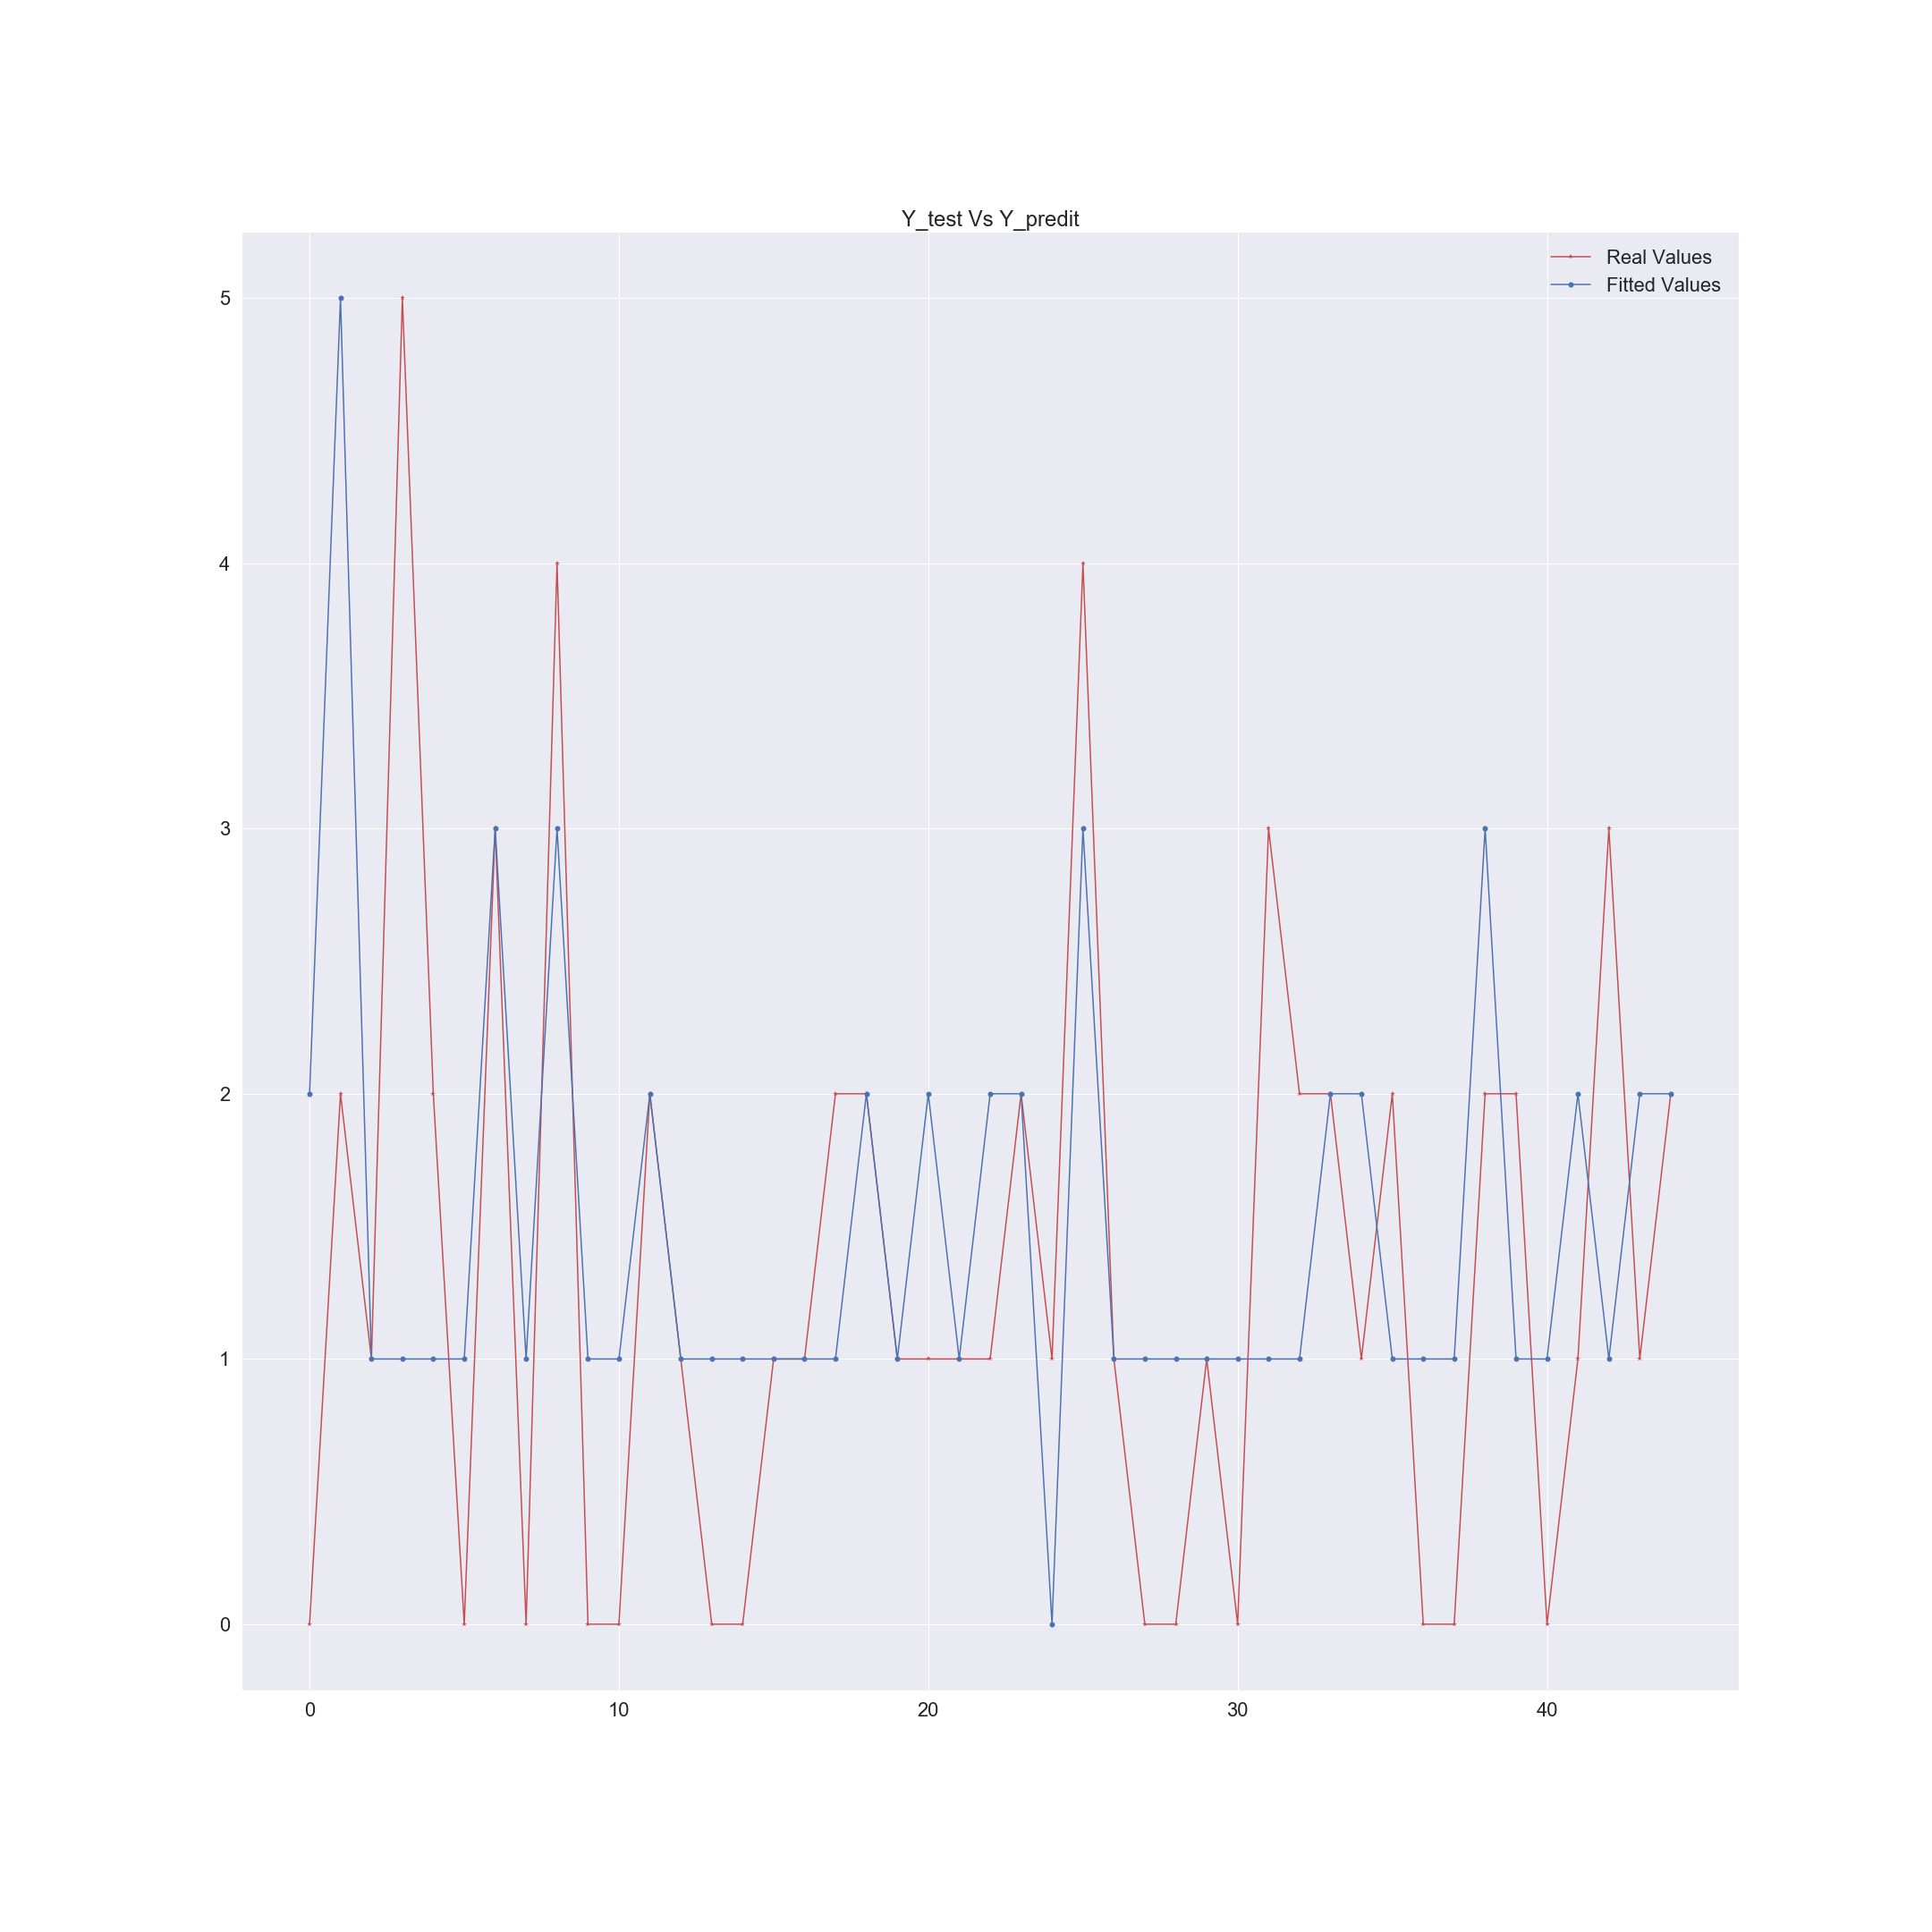

In [37]:
%matplotlib notebook
preds = np.round(pred2.iloc[:,1])
plt.plot(range(len(y_test3)), y_test3, 'r*-', range(len(y_test3)), preds, 'bo-')
plt.title('Y_test Vs Y_predit')
plt.legend(['Real Values', 'Fitted Values'])
plt.show()

In [38]:
%matplotlib notebook
Result3['Mayor0_test'] = (Result3['pred1']>0).astype(int)
Result3['Mayor0_real'] = (Result3['y_ts']>0).astype(int)
Result3['prueba']= [0]*len(Result3['Mayor0_real'])
sum=0
for i in range(len(Result3['Mayor0_real'])):
    if Result3.Mayor0_real[i]==Result3.Mayor0_test[i]:
        Result3['prueba'][i]=1
        sum=sum+1
    else: Result3['prueba'] [i]=0
accu=sum/len(Result3['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result3['Mayor0_test'],Result3['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result3, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

#sns.heatmap(confusion_matrix, annot=True)

Val 0 y >0:  0.6888888888888889
Predicted   0   1
Actual           
0           0   1
1          13  31
